<a href="https://colab.research.google.com/github/yogi05AI/niyata_task_1_sales/blob/main/Niyata_sales_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")
store_info = pd.read_csv("/content/stores.csv")
oil_prices = pd.read_csv("/content/oil.csv")
holidays = pd.read_csv("/content/holidays_events.csv")

In [3]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [4]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [5]:
for df in [train_data, test_data, oil_prices, holidays]:
    df["date"] = pd.to_datetime(df["date"], errors='coerce')

# Check for NaT (invalid dates)
for df_name, df in zip(["train_data", "test_data", "oil_prices", "holidays"], [train_data, test_data, oil_prices, holidays]):
    invalid_dates = df[df["date"].isna()]
    if not invalid_dates.empty:
        print(f"Warning: {len(invalid_dates)} invalid date values found in {df_name}. These will be removed.")
        df.dropna(subset=["date"], inplace=True)  # Remove rows with invalid dates


In [6]:
# Fill missing oil prices
oil_prices["dcoilwtico"].fillna(method='ffill', inplace=True)

<ipython-input-6-748ac492282a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  oil_prices["dcoilwtico"].fillna(method='ffill', inplace=True)
<ipython-input-6-748ac492282a>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_prices["dcoilwtico"].fillna(method='ffill', inplace=True)


In [7]:
# Merge datasets with suffixes to avoid duplicate columns
train_data = train_data.merge(store_info, on="store_nbr", how="left", suffixes=("", "_store"))
train_data = train_data.merge(oil_prices, on="date", how="left")
train_data = train_data.merge(holidays, on="date", how="left", suffixes=("", "_holiday"))

test_data = test_data.merge(store_info, on="store_nbr", how="left", suffixes=("", "_store"))
test_data = test_data.merge(oil_prices, on="date", how="left")
test_data = test_data.merge(holidays, on="date", how="left", suffixes=("", "_holiday"))

In [8]:
train_data.shape

(296067, 16)

In [9]:
test_data.shape

(28512, 15)

In [10]:
# Feature Engineering
for df in [train_data, test_data]:
    df["day"] = df["date"].dt.day
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["dayofweek"] = df["date"].dt.dayofweek
    df.fillna(0, inplace=True)

In [11]:
# Fill missing values
train_data.fillna(0, inplace=True)

In [12]:
# Convert object columns to categorical codes
for df in [train_data, test_data]:
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category').cat.codes

In [13]:
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Split data
X = train_data.drop(columns=["sales", "date"])
y = train_data["sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Train XGBoost Model
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
# Hyperparameter Tuning for XGBoost
xgb_params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6]}

xgb_grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), xgb_params, cv=2, scoring='neg_mean_absolute_error')
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 6],
                         'n_estimators': [50, 100]},
             scoring='neg_mean_absolute_error')

In [15]:
xgb_model = xgb_grid.best_estimator_
xgb_predictions = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f"XGBoost Model: MAE = {xgb_mae:.2f}, RMSE = {xgb_rmse:.2f}")

XGBoost Model: MAE = 63.41, RMSE = 163.96


In [16]:
# Hyperparameter Tuning for Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_params = {'n_estimators': [50, 100], 'max_depth': [None, 10]}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=2, scoring='neg_mean_absolute_error')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_absolute_error')

In [17]:
rf_model = rf_grid.best_estimator_
rf_predictions = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest Model: MAE = {rf_mae:.2f}, RMSE = {rf_rmse:.2f}")

Random Forest Model: MAE = 26.37, RMSE = 110.60


In [19]:
# Train Decision Tree Model
from sklearn.tree import DecisionTreeRegressor
# Hyperparameter Tuning for Decision Tree
dt_params = {'max_depth': [50, 100, None]}

dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=2, scoring='neg_mean_absolute_error')
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [50, 100, None]},
             scoring='neg_mean_absolute_error')

In [20]:
dt_model = dt_grid.best_estimator_
dt_predictions = dt_model.predict(X_test)

dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_predictions))
print(f"Decision Tree Model: MAE = {dt_mae:.2f}, RMSE = {dt_rmse:.2f}")

Decision Tree Model: MAE = 34.46, RMSE = 147.26


In [21]:
# Display Model Comparison
results = {
    "XGBoost": {"MAE": xgb_mae, "RMSE": xgb_rmse},
    "Random Forest": {"MAE": rf_mae, "RMSE": rf_rmse},
    "Decision Tree": {"MAE": dt_mae, "RMSE": dt_rmse},
}
print("\nModel Comparison:")
print(pd.DataFrame(results).T)


Model Comparison:
                     MAE        RMSE
XGBoost        63.405379  163.959795
Random Forest  26.370853  110.602537
Decision Tree  34.464372  147.261901


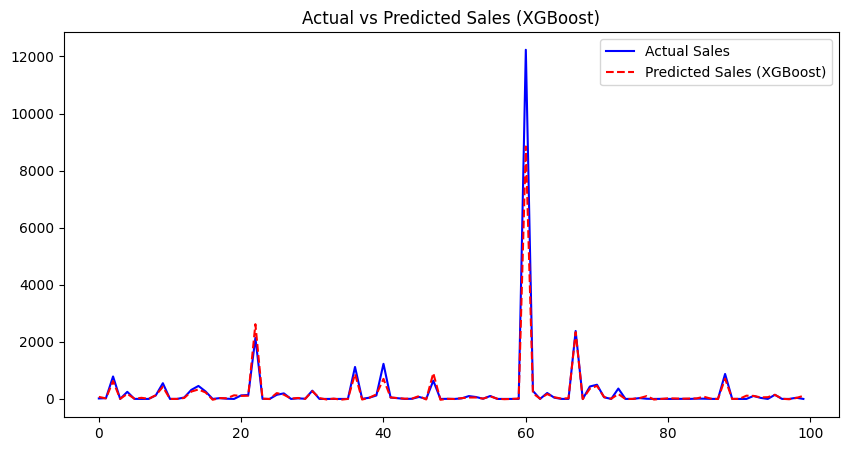

In [22]:
# Plot Actual vs Predicted Sales for XGBoost
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Actual Sales', color='blue')
plt.plot(xgb_predictions[:100], label='Predicted Sales (XGBoost)', color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs Predicted Sales (XGBoost)")
plt.show()